## Project: Ensemble Model
1. Fit and tune Random Forest and Gradient Boosting Models
2. Plot ROC curves for both models
3. Select the model with best AUC, then tune the threshold to maximize F1
4. Build a Beeswarm plot of SHARP values

### Step 1: Data Prep & EDA

1. Import the data - perform any datatype conversion as necessary
2. Modify the target variable - Group 'Standard' and 'Good' Credit together to create a binary classification problem
3. Explore the Data - which features appear to impact credit score group the most? Are any features highly correlated with each other? Remove any unnecessary features.
4. Prepare your data for modelling. Create dummy variables, split your data into train and test, and scale your features if necessary.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

credit_df = pd.read_csv("../Data/credit_train_clean.csv").drop(["Name", "SSN", "ID", "Customer_ID"], axis=1)

credit_df.info()

In [3]:
credit_df["target"] = credit_df["Credit_Score"].map(
    {
        "Good": 0,
        "Standard": 0,
        "Poor": 1
        
    }
)

credit_df.drop('Credit_Score',axis=1,inplace=True)

In [4]:
## Prepare the data
features = [
    "Age",
    "Month",
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Num_of_Delayed_Payment",
    "Credit_Utilization_Ratio",
    "Amount_invested_monthly",
    "Interest_Rate",
    "Num_Bank_Accounts",
    "Changed_Credit_Limit",
    "Num_Credit_Card",
    "Credit_History_Age", 
    "Payment_of_Min_Amount", 
    "Monthly_Balance", 
#     "Payment_Behaviour",
    "Num_Credit_Inquiries",
    "Outstanding_Debt",
    "Credit_Mix",
    "Total_EMI_per_month",
#     "Type_of_Loan", 
    
]

X = pd.get_dummies(credit_df[features], drop_first=True)
y = credit_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1012)

### Random Forest Model

In [5]:
rf = RandomForestClassifier(random_state=1024)
rf.fit(X_train, y_train)

print(f'Training Accuracy: {rf.score(X_train, y_train)}')
print(f'Testing Accuracy: {rf.score(X_test, y_test)}')

Training Accuracy: 1.0
Testing Accuracy: 0.8961


### Gradient Boosting Model

In [6]:
gb = GradientBoostingClassifier(random_state=1023)
gb.fit(X_train, y_train)

print(f'Training Accuracy: {gb.score(X_train, y_train)}')
print(f'Testing Accuracy: {gb.score(X_test, y_test)}')

Training Accuracy: 0.832425
Testing Accuracy: 0.8298


### Tune Random Forest Model

In [8]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'n_estimators': np.arange(100,1100,100),
    'max_features': [None, 'sqrt'],
    'bootstrap': [True],
    'max_samples': [None, 0.3, 0.5, 0.9],
    'max_depth': np.arange(1, 11, 1),
    'min_samples_leaf': [2, 5, 10, 20, 100]
}

grid = RandomizedSearchCV(
    rf,
    param_distributions=params,
    n_iter=10,
    n_jobs=-1,
    scoring='accuracy'
)

grid.fit(X_train, y_train)
grid.best_params_

{'n_estimators': np.int64(300),
 'min_samples_leaf': 20,
 'max_samples': 0.3,
 'max_features': None,
 'max_depth': np.int64(8),
 'bootstrap': True}

In [10]:
rf_tuned = RandomForestClassifier(**grid.best_params_)
rf_tuned.fit(X_train, y_train)

print(f'Training Accuracy: {rf_tuned.score(X_train, y_train)}')
print(f'Testing Accuracy: {rf_tuned.score(X_test, y_test)}')

Training Accuracy: 0.8375125
Testing Accuracy: 0.8341


### Tune Gradient Boosting Model

In [12]:
params = {
    "n_estimators": np.arange(100,1100,100),
    "learning_rate": [.001, .01],
    "max_features": [None, "sqrt"],
    "subsample": [.8, .9, 1.0],
    "max_depth": np.arange(3, 12, 2),
    "min_samples_leaf": [2, 5, 10]
}

grid = RandomizedSearchCV(
    gb,
    param_distributions=params,
    n_iter=10,
    n_jobs=-1,
    scoring="accuracy"
)

grid.fit(X_train, y_train)

grid.best_params_

Exception ignored in: <function ResourceTracker.__del__ at 0x10ef87100>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10d013100>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
Chi

{'subsample': 1.0,
 'n_estimators': np.int64(1000),
 'min_samples_leaf': 5,
 'max_features': None,
 'max_depth': np.int64(7),
 'learning_rate': 0.01}

In [13]:
gb_tuned = GradientBoostingClassifier(**grid.best_params_)
gb_tuned.fit(X_train, y_train)

print(f'Training Accuracy: {gb_tuned.score(X_train, y_train)}')
print(f'Testing Accuracy: {gb_tuned.score(X_test, y_test)}')


Training Accuracy: 0.8736875
Testing Accuracy: 0.8565


### Fit ROC curve for both models

In [17]:
from sklearn.metrics import roc_curve, auc

## Tuned RF Model
y_probs = rf_tuned.predict_proba(X_test)[:,1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs)

auc_score_rf = auc(fpr, tpr)

In [20]:
## tunes GB model
y_probs = gb_tuned.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_probs)

auc_score_gb = auc(fpr_gb, tpr_gb)

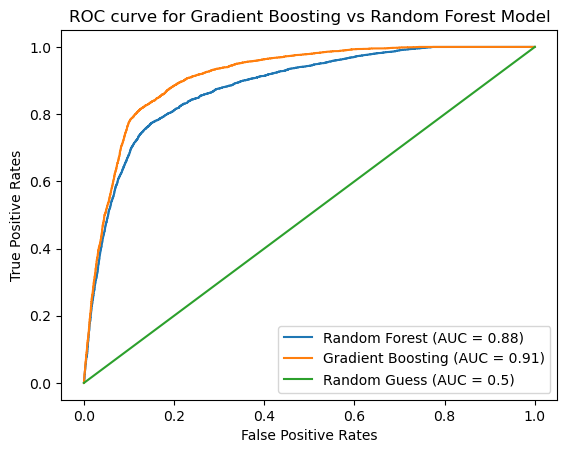

In [22]:
#Plot ROC curve
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_score_rf:0.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {auc_score_gb:0.2f})')

#Draw Random Guess
plt.plot([0,1],[0,1], label='Random Guess (AUC = 0.5)')

#Format the axes
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.title('ROC curve for Gradient Boosting vs Random Forest Model')
plt.legend()
plt.show();

Optimum Threshold for Random Forest: 0.39 with F1 score 0.7415495554554021
Optimum Threshold for Gradient Boosting: 0.4 with F1 score 0.8022469094553959


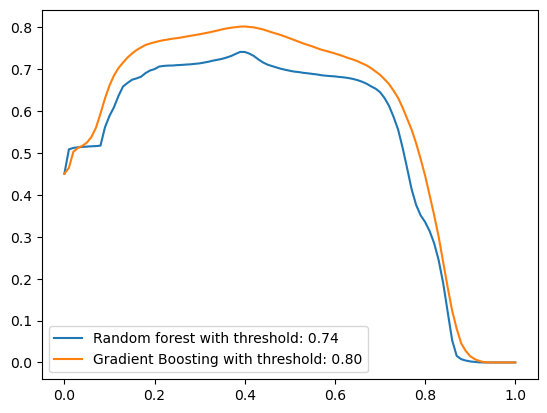

In [27]:
## Plot F1 curve

## Random Forest
f1_rf = []

thresholds_rf = np.linspace(0, 1, 101)

for thresh in thresholds_rf:
    y_pred = (rf_tuned.predict_proba(X_train)[:,1]>thresh)
    f1_rf.append(f1_score(y_train, y_pred))

## Gradient Boosting
f1_gb = []

thresholds_gb = np.linspace(0, 1, 101)

for thresh in thresholds_gb:
    y_pred = (gb_tuned.predict_proba(X_train)[:,1]>thresh)
    f1_gb.append(f1_score(y_train, y_pred))

sns.lineplot(x=thresholds_rf, y=f1_rf, label=f'Random forest with threshold: {max(f1_rf):.2f}');
sns.lineplot(x=thresholds_gb, y=f1_gb, label=f'Gradient Boosting with threshold: {max(f1_gb):.2f}')

plt.legend()
# f1 = np.array(f1)

# max_index = np.argmax(f1)

thresh_rf = thresholds_rf[f1_rf.index(max(f1_rf))]
thresh_gb = thresholds_gb[f1_gb.index(max(f1_gb))]


print(f'Optimum Threshold for Random Forest: {thresh_rf} with F1 score {max(f1_rf)}')

print(f'Optimum Threshold for Gradient Boosting: {thresh_gb} with F1 score {max(f1_gb)}')


### Explain features using SHAP


In [35]:
import shap

explainer = shap.Explainer(gb_tuned)

shap_values = explainer(X_test.sample(80, random_state=1040))

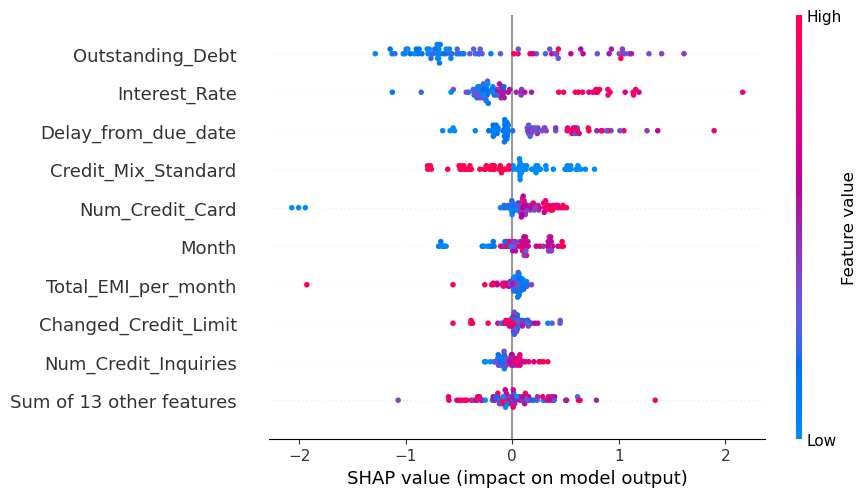

In [36]:
shap.plots.beeswarm(shap_values)

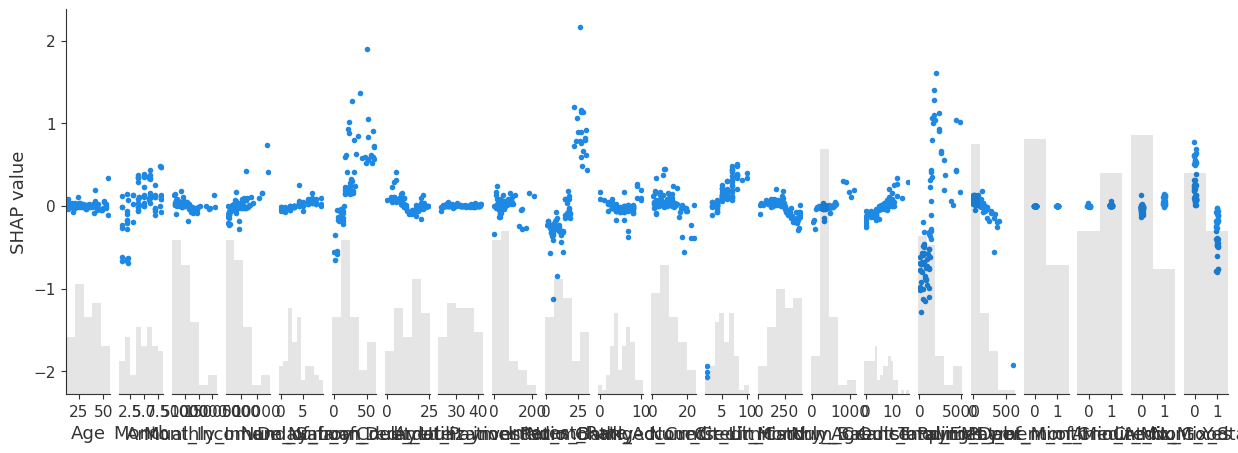

In [37]:
shap.plots.scatter(shap_values)

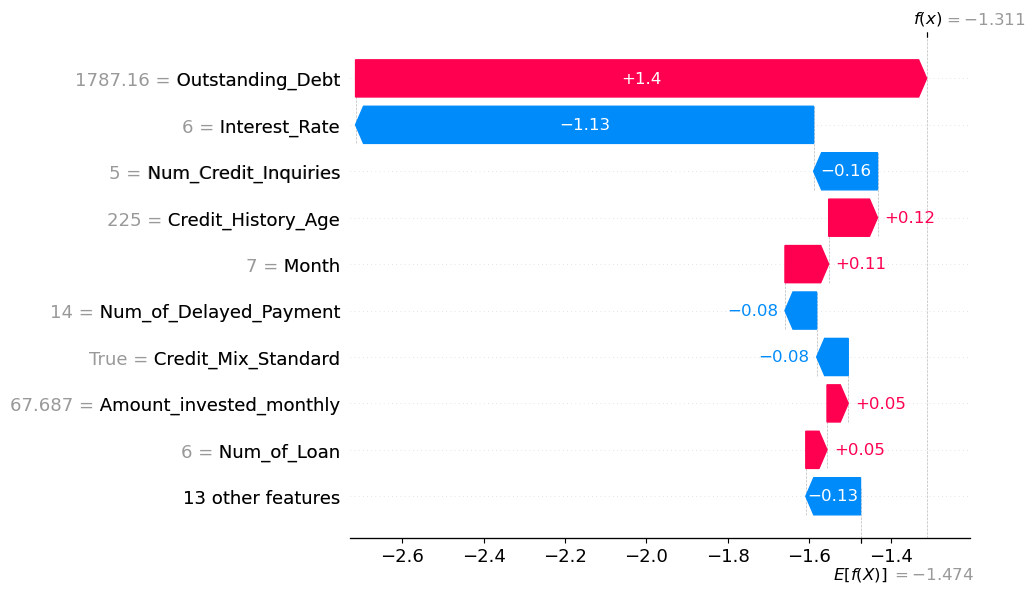

In [39]:
shap.plots.waterfall(shap_values[0])

In [40]:
shap_values

.values =
array([[-3.68934446e-02,  1.07349827e-01, -3.75101200e-03, ...,
         2.95718299e-03, -1.20127128e-02, -7.76236688e-02],
       [ 3.13526712e-02,  9.78500429e-02, -4.56103473e-02, ...,
        -1.74164669e-03,  5.74960599e-02,  5.03693426e-01],
       [ 5.78946111e-03, -2.81883071e-01,  3.67952174e-04, ...,
        -4.47072796e-04,  1.03810554e-01,  5.32146942e-01],
       ...,
       [ 5.20686728e-03,  1.13937205e-01,  4.53856557e-02, ...,
        -2.30515252e-03, -3.02421735e-02,  7.44382516e-02],
       [ 1.94976629e-01,  1.31084538e-01,  1.26397207e-01, ...,
         2.87760524e-02,  4.86183903e-02,  5.98690763e-01],
       [ 1.06052959e-01,  3.47473393e-01, -4.74408824e-03, ...,
        -1.82002333e-03, -2.41098141e-02, -4.05227434e-01]],
      shape=(80, 22))

.base_values =
array([-1.47388401, -1.47388401, -1.47388401, -1.47388401, -1.47388401,
       -1.47388401, -1.47388401, -1.47388401, -1.47388401, -1.47388401,
       -1.47388401, -1.47388401, -1.47388401, -1.47